# Python Learn by Doing: Climate Change Indicators, Your Turn! Option 3 Answer Key

**Developed By:** Dr. Kerrie Geil, Mississippi State University

**Original Development Date:** May 2024

**Package Requirements:** xarray, netcdf4, numpy, pandas, scipy, matplotlib, jupyter

**Links:** **[OSF project link](https://osf.io/zhpd5/)**, [link to this notebook on github](https://github.com/kerriegeil/MSU_py_training/blob/main/learn_by_doing/climate_change_indicators/assignments/climate_change_indicators_option3.ipynb)

---
**Assignment:**

Calculate the warm spell duration index (WSDI) at Starkville, determine whether there is a statistically significant trend, and create a figure showing the WSDI timeseries, linear trend, and p value. Compare your results to climdex.org, looking at the trend in WSDI over CONUS for similar data years (1977-2021) and also for data years 1922-2021 from the Berkeley Earth Surface Temperature dataset.

&emsp;Hints:
- Use daily tmax data but drop leap days entirely
- Calculate WSDI using the following criteria
    - 6 consecutive days of hot maximum temperatures
    - hot temperature threshold defined as > 90th percentile of tx for each calendar day using a centered 5-day window in the base period 1981-2010
    - warm spells that contain dates over multiple years are assigned to the year when the spell ends
- Determine if there is a statistically significant trend in DTR at the 90% confidence level
- Plot the DTR timeseries with its linear trend line. Your plot should have x axis tick labels as years, a y axis label that describes the units, and a title that includes the p value.
- Go to **[climdex.org](https://www.climdex.org/access/)** and get the png of WSDI trend over CONUS using data years 1977-2021 from the BEST dataset
- Go to **[climdex.org](https://www.climdex.org/access/)** and get the png of WSDI trend over CONUS using data years 1922-2021 from the BEST dataset

# Import packages and define workspace

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt

In [ ]:
# filenames 
tmax_f='data/tmax_AgERA5_Starkville_Daily_1979-2023.nc'

# Data Cleaning

Normally, we would run through the data cleaning suggested by ETCCDI here. However, we've already done the data cleaning steps in climate_change_indicators.ipynb and found that the leap days step was the only step that changed our data arrays. We'll repeat only that step here.

In [ ]:
tx = xr.open_dataarray(tmax_f)
tx = tx.squeeze()

tx

In [ ]:
#### leap days (i.e Feb 29th)

# create a boolean array of dim 'time' where leapdays are True and all other days are False
isleapday=xr.where((tx.time.dt.day==29) & (tx.time.dt.month==2),True,False)

# drop leap days 
tx=tx.where(~isleapday,drop=True) 

#  Climate change indicator: Warm Spell Duration Index (WSDI)

- 6 consecutive days of hot maximum temperatures
- hot temperature threshold defined as > 90th percentile of tx for each calendar day using a centered 5-day window in the base period 1981-2010
- warm spells that contain dates for multiple years are assigned to the year when the spell ends

Here we first use daily data during the base period to determine the daily 90th percentile temperature threshold. Then using all years of daily data we decide whether each calendar day exceeds the hot threshold, then find occurrences where the threshold is exceeded for at least 6 consecutive days (this is a warm spell), then sum the number of days annually in the warm spells.

Notice that this is not the same as finding dangerous heat waves with respect to human health because it is based on a percentile temperature for each calendar day. This means that the WSDI will include winter warm spells where the temperature exceeds the daily 90th percentile, which would likely be a comfortable temperature.

## Step 1: calculate daily 90th percentile temperature

- drop leap days
- use a centered 5 day window
- use a base period 1981-2010 plus two extra days before and after

This means that to determine the 90th percentile temperature for a given day we need that day's temperature in each base year as well as the temperature for 2 days before and 2 days after

In [ ]:
# drop leap days and subset to the base period but include two extra days before and after
# the time labels are real nice for this
tx_baseyrs=tx.sel(time=slice('1980-12-30','2011-01-02'))
tx_baseyrs

In [ ]:
# first make a day-of-year coordinate label for tx_noleap_baseyrs
n_baseyrs=30
day_first=1
day_last=365

# a list of numbers 1 through 365
doy=list(np.arange(day_first,day_last+1))

# repeat the list to match the number of base years
doy=doy*n_baseyrs

# add values for the 2 extra days before and after the base years
doy= [364,365] + doy + [1,2]

# doy should have the same length as tx_noleap_baseyrs.time
assert len(doy)==len(tx_baseyrs.time), f'tx_baseyrs time dim has {len(tx_baseyrs.time)} and doy has {len(doy)} values'

# look at the first few values of doy
doy[0:9]

In [ ]:
# assign doy as a new coordinate
tx_baseyrs.coords['doy']=('time',doy)
tx_baseyrs

In [ ]:
# construct 5-day centered windows
tx_windows=tx_baseyrs.rolling(time=5,center=True).construct('window')
tx_windows

In [ ]:
# drop the windows centered on days outside the base period
tx_windows=tx_windows.drop_sel(time=['1980-12-30','1980-12-31','2011-01-1','2011-01-02'])
tx_windows

In [ ]:
# now groupby our doy coordinate
# each group will contain the temperature for a single doy of every year plus the two days before and two days after
# in other words, each group is the 5-day centered window for a given doy for all years 
# 5 days * 30 years = 150 data values in each group
tx_grouped=tx_windows.groupby(tx_windows.doy)

# let's look at what is in a data group for doy 15
tx_grouped[15]

In [ ]:
# now find the 90th percentile of data values in each group
# we should end up with 1 value for each doy of the year (excluding leap days)
threshold90=tx_grouped.quantile(0.9,dim=['time','window'])
threshold90

## Step 2: identify every day that is above the daily 90th percentile temperature 

don't worry about the consecutive days criteria yet

In [ ]:
# prep tx for comparison to threshold90

# and add doy coordinate
nyears=45
doy=list(np.arange(day_first,day_last+1))*nyears
tx.coords['doy']=('time',doy)

tx

In [ ]:
# determine which days exceed threshold90 (these are the hot days)
# we'll create a boolean array
tx_hot_mask = tx.groupby(tx.doy) > threshold90

# how many True days and how many False?
ntrue=tx_hot_mask.sum()
nfalse=len(tx_hot_mask)-ntrue
print(f"{ntrue.data} hot days and {nfalse.data} days that aren't hot")

tx_hot_mask

## Step 3: identify warm spells and determine which year each warm spell occurs in

- warms spells are at least 6 consecutive hot days
- warm spells that span over multiple years should be assigned to the year when the spell ends


In [ ]:
# we'll loop in time to identify warm spells in each year
# and save the index of every day in every warm spell
ndays=6

hot_inds=[]  # empty list to hold the results
count=0

# loop through the boolean array
for i,value in enumerate(tx_hot_mask):

    # if True start a counter
    if value: count=count+1
    else: count=0

    # when the count reaches 6
    # save all the True indexes to our results list
    # the results will include duplicates that we'll remove later
    if count>=ndays:
        inds=np.arange(i-(ndays-1),i+1)
        hot_inds.extend(inds)

# now remove duplicates
hot_inds=np.unique(hot_inds)

# how many total days in all warm spells
len(hot_inds)

In [ ]:
# get the start and stop index of each warm spell
# so we can assign each warm spell to the correct year

events=[]  # empty list to hold the results
ind_start=None  # initialize

# loop through the index values of all warm spell days
for i,value in enumerate(hot_inds[:-1]):
    # find the first warm spell start
    if ind_start==None:
        ind_start=value

    # find the ending index and the start of the next warm spell 
    # if the next index increments by 1 keep searching
    if hot_inds[i+1]==value+1:
        pass
    # if the next index increments by more than 1
    # then this is the end and the next value is the start of the next event
    else:
        ind_end=value
        events.append((ind_start,ind_end)) # append a tuple
        ind_start=hot_inds[i+1]

print(f'there are {len(events)} warm spells in our data')

# print the first 5 items in events
events[:5]

In [ ]:
# assign a year to each warm spell and count how many span over more than 1 year

spell_year=[]  # empty list to hold the results
count=0

for ind_start,ind_end in events:
    year_start=int(tx_hot_mask.time.isel(time=ind_start).dt.year)#.data
    year_end = int(tx_hot_mask.time.isel(time=ind_end).dt.year)#.data
    if year_start==year_end:
        spell_year.append(year_start)
    else:
        spell_year.append(year_end)
        count+=1

print(f'{count} warm spell(s) start in Dec of one year and end in Jan of the next year')

# print the first 10 items in spell_year
spell_year[:10]

## Step 4: count how many warm spells days per year and plot it

In [ ]:
# count days in warm spells per year

WSDI=[]  # empty list to hold the results

# loop through all data years
for data_year in np.arange(1979,2023+1):
    days_per_year=0  
    
    # loop through all warm spells
    for i,event_year in enumerate(spell_year):
        if event_year==data_year:
            # get days per event
            ndays=events[i][1]-events[i][0]+1
            days_per_year=days_per_year+ndays
            del ndays
        
    WSDI.append(days_per_year)

# print the first 5 items
WSDI[:5]

In [ ]:
# plot it

# create annual datetimes for x axis values
time_annual=pd.date_range(tx.time.data[0],tx.time.data[-1],freq='YS')

# plot
fig=plt.figure(figsize=(15,2))
plt.plot(time_annual,WSDI)
plt.title('Warm Spell Duration Index (WSDI)')
plt.show()

# Trend analysis

In [ ]:
# linear regression
reg_info=ss.linregress(time_annual.year,WSDI)

# convert trend units
trend=reg_info.slope*100 # days/year --> days/century

# create regression line for plotting
regline=reg_info.slope*time_annual.year +reg_info.intercept

In [ ]:
# plot the linear regression over the data and show p value
fig=plt.figure(figsize=(15,2))

plt.plot(time_annual.year,WSDI)  # the climate change index
plt.plot(time_annual.year,regline,linestyle='--')  # the linear regression line

plt.axhline(y=np.asarray(WSDI).mean(),color='grey',linestyle='dashed',linewidth=0.5)  # a guide line, the data mean
plt.tick_params(labelright=True, right=True)  # add ticks and tick labels to right-side axis
plt.ylabel('days') # y axis label
plt.title(f'warm spell duration with trend {trend:.2f} days/century (p={reg_info.pvalue:.3f})')

# plt.savefig('figs/cci_option3_figure.png')
plt.show() # plot it all together

# Conclusions

With a p value of 0.354, there is no statistically significant trend in Starkville WSDI.

We find a similar result at Starkville on climdex.org, using BEST data over the years 1977-2021 to calculate WSDI trend. However, there do appear to be significant trends of increasing WSDI across much of the southwest US and Pacific coast.

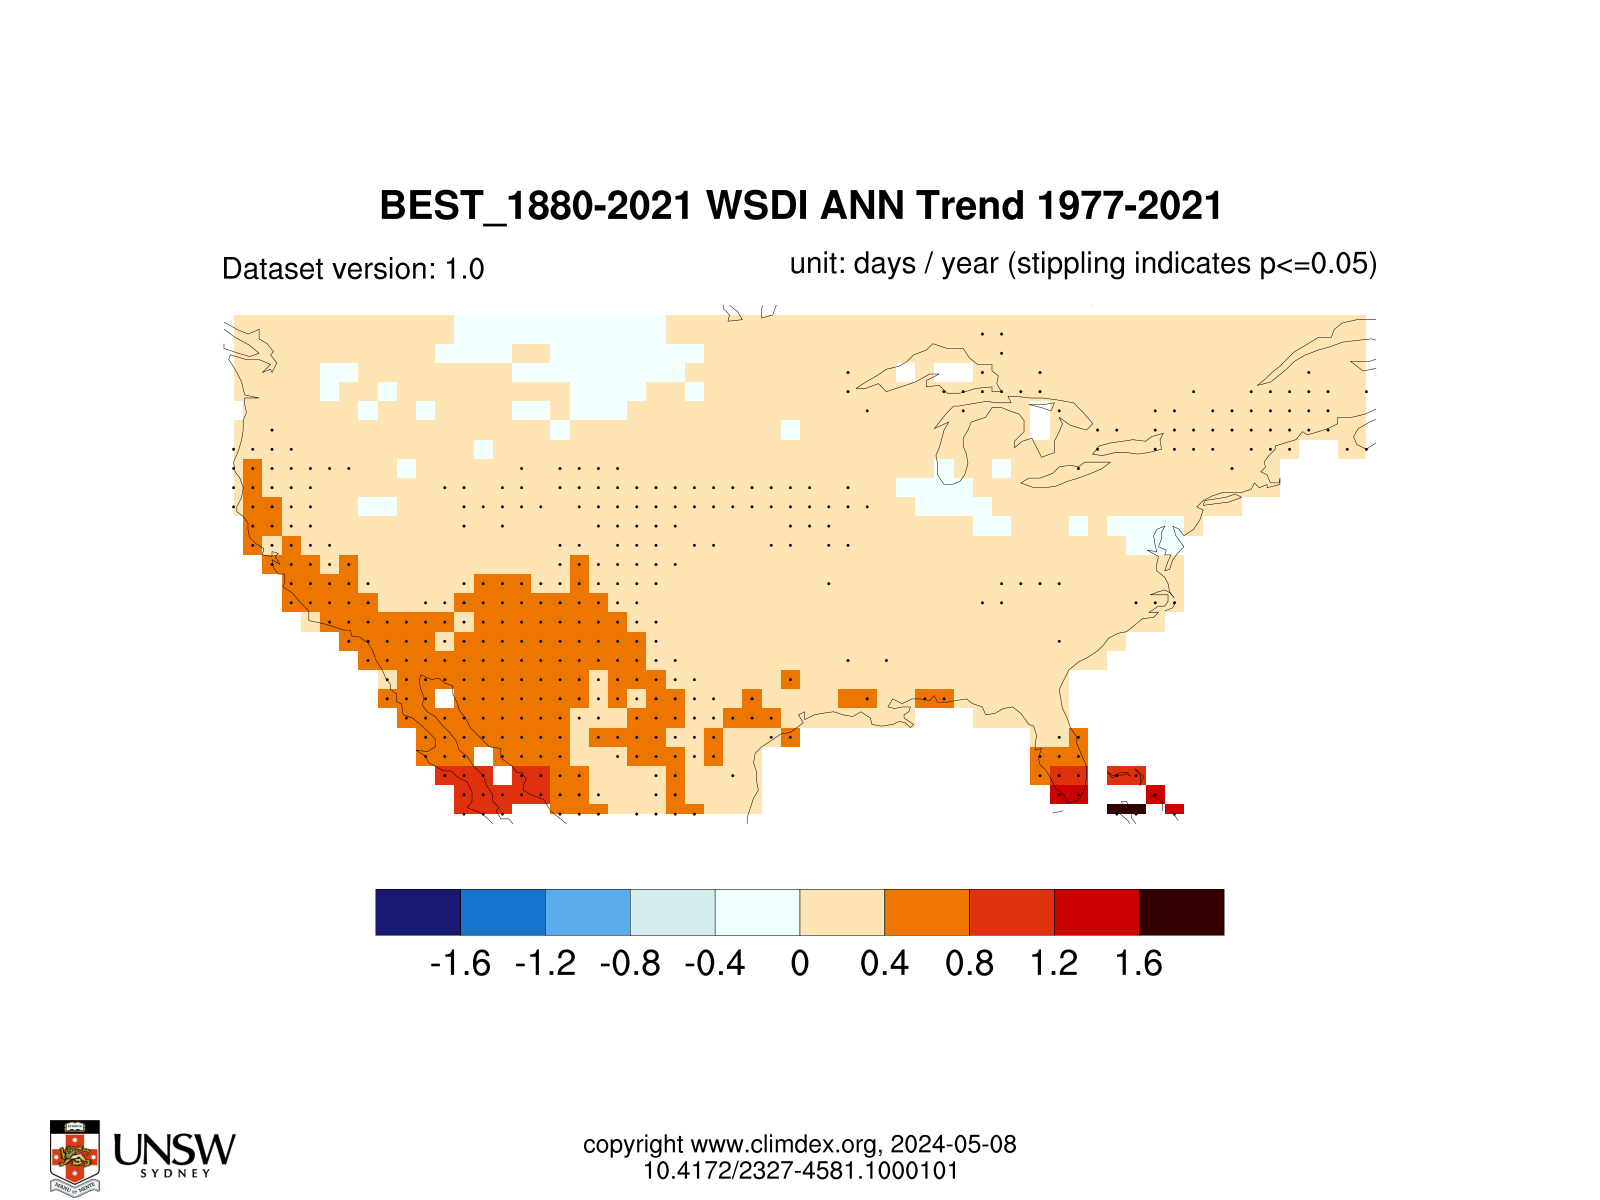

<br>
<br>

If the trends above are robust long term trends, then we should see a similar result using more data years. If we use 100 total data years, do we see the same pattern of trends and similar areas of statistical significance over CONUS? 


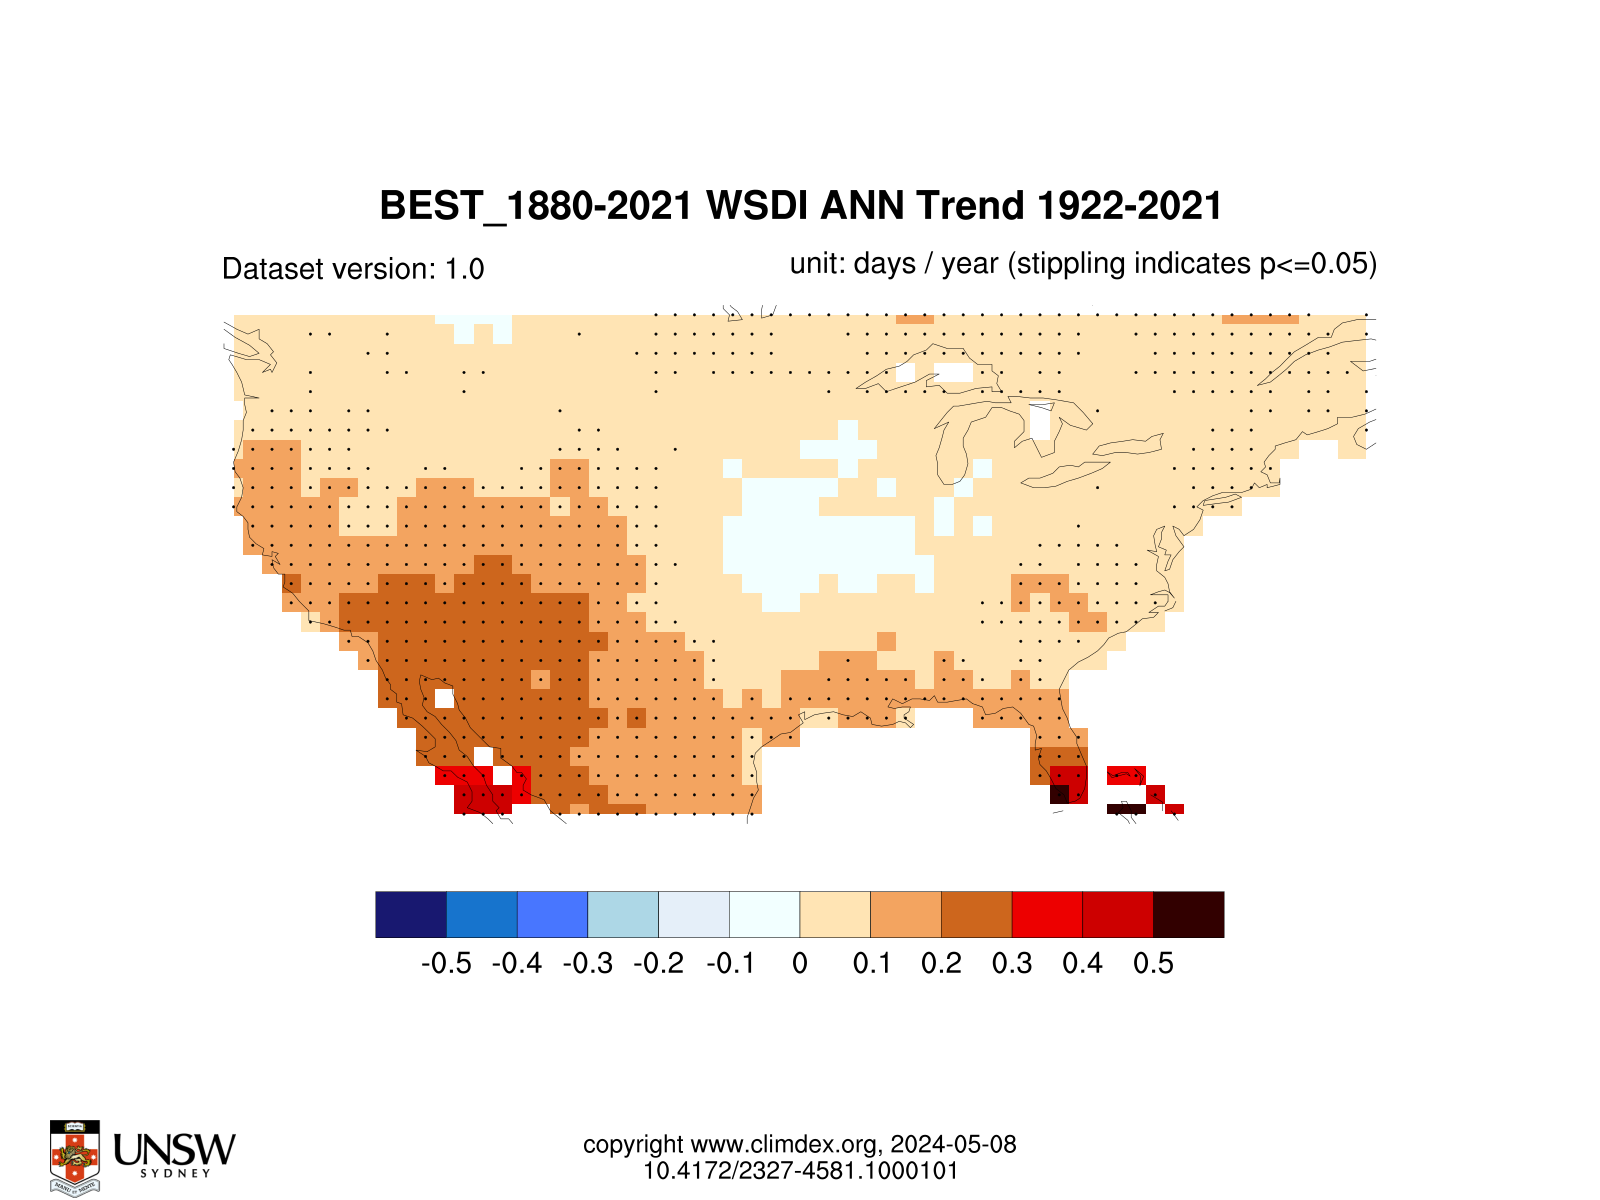

The 100-year trend in WSDI is statistically significant for much of the country, except for a large hole across the Plains and Midwest.